In [14]:
# Import things
%matplotlib inline
import matplotlib
#matplotlib.use('Agg')

import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as md
import pandas as pd
from matplotlib import rcParams
import os
import glob
from scipy import io

# Supress warnings for sake of log file
import warnings
warnings.filterwarnings("ignore")

# Plotting preferences

rcParams['xtick.direction'] = 'in'
rcParams['ytick.direction'] = 'in'
rcParams.update({'font.size': 16}) 
rcParams['axes.titlepad'] = 14 
rcParams['xtick.major.pad']='10'
rcParams['ytick.major.pad']='10'
myFmt = md.DateFormatter('%d/%m')
rule = md.DayLocator(interval=1)

In [10]:

def get_opc(opc_n,d_loc,d1,d2):
    os.chdir(d_loc)                  # Change directory to where the data is
    #log = open(log_licor,'w')             # Open the log file for writing
    all_files = glob.glob('*%s*OPC*'%opc_n)
    if opc_n=='TAWO':
        file_dates = np.asarray([(dt.datetime.strptime(f[-12:-4], '%Y%m%d')).date() for f in all_files])
    else:
        file_dates = np.asarray([(dt.datetime.strptime(f[-14:-4], '%Y-%m-%d')).date() for f in all_files])
           
    idxs = np.where(np.logical_and(file_dates>=d1.date(), file_dates<=d2.date()))[0]
    dfs = [all_files[i] for i in idxs]
    opc = pd.DataFrame()
    # Extract the data
    for f in dfs: 
        # Ignore file if it's empty
        if os.path.getsize(f)==0:
            #log.write('Error with: '+f+' this file is empty.\n')
            continue 
        opc = opc.append(pd.read_csv(f, skiprows=4,sep=',',error_bad_lines=False))  
    opc['Dates'] = pd.to_datetime(opc['time'],format='%Y-%m-%d %H:%M:%S')
    opc = opc.sort_values('Dates')
    opc = opc.set_index(opc['Dates'])
    opc.index = pd.DatetimeIndex(opc.index)
    #opc = opc[~opc.index.duplicated()]
    del opc['time'], opc['Dates']

    # Convert flow rate from L/min to cm3/s
    # 1 L/min = 16.66667 cm3/s
    opc.FlowRate = opc.FlowRate/100 * 16.66667

    # Get total counts
    opc['total_counts']=opc['b0'].astype(float)+ opc['b1'].astype(float)+ opc['b2'].astype(float)+ opc['b3'].astype(float)+ opc['b4'].astype(float)+ opc['b5'].astype(float)+ opc['b6'].astype(float)+ opc['b7'].astype(float)+ opc['b8'].astype(float)+ opc['b9'].astype(float)+ opc['b10'].astype(float)+ opc['b11'].astype(float)+ opc['b12'].astype(float)+ opc['b13'].astype(float)+ opc['b14'].astype(float)+ opc['b15'].astype(float)+ opc['b16'].astype(float)+ opc['b17'].astype(float)+ opc['b18'].astype(float)+ opc['b19'].astype(float)+ opc['b20'].astype(float)+ opc['b21'].astype(float)+ opc['b22'].astype(float)+ opc['b23'].astype(float)
    opc['total_counts']=opc['total_counts'].replace({0: np.nan})
    # Convert total counts/interval to total counts/s
    opc.period = opc.period/100 # period in s
    opc.total_counts = opc.total_counts /opc.period
    # Convert total counts/second to counts/cm3
    opc['OPC_conc'] = opc.total_counts / opc.FlowRate

    return opc



In [11]:
d_loc='/Users/heather/ICECAPS-ACE/temp_data/home/data/'
# Get plot times
d1 = dt.datetime(2019,5,28)
d2 = dt.datetime(2019,9,1)

TAWO_OPC = get_opc('TAWO',d_loc,d1,d2)


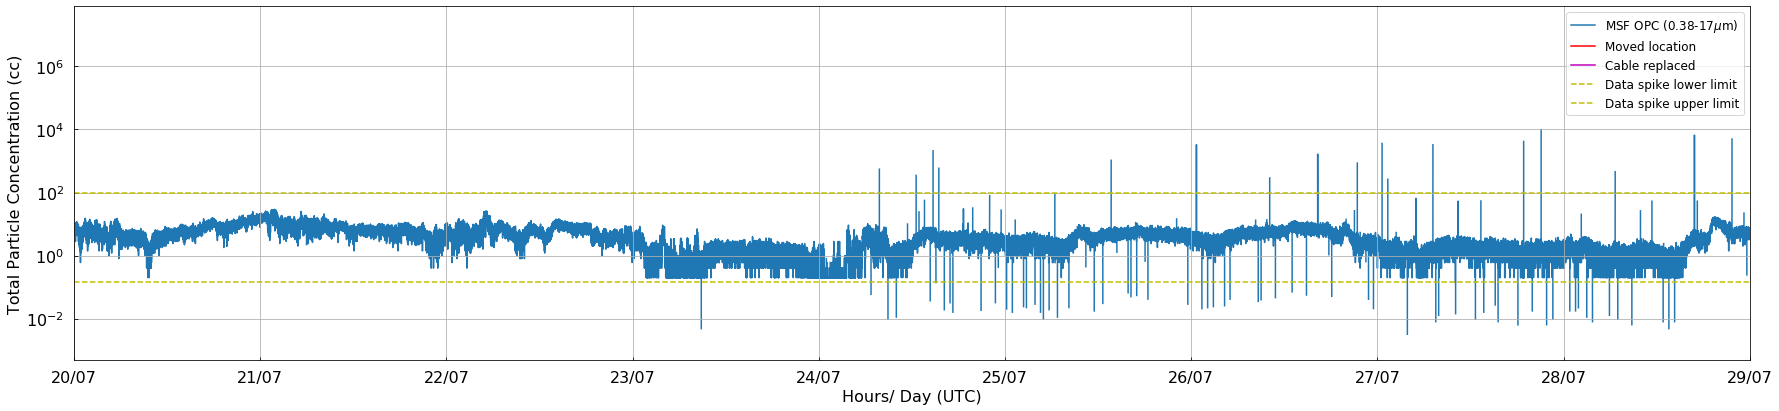

In [15]:

# Plot & save 
fig = plt.figure(figsize=(25,6))
ax = fig.add_subplot(111)
ax.grid(True)
ax.semilogy(TAWO_OPC.index,TAWO_OPC.total_counts,label = 'MSF OPC (0.38-17$\mu$m)',zorder=1)  
ax.axvline(dt.datetime(2019,8,21,18),label='Moved location',c='r')
ax.axvline(dt.datetime(2019,8,29,16,42),label='Cable replaced',c='m')

ax.axhline(0.15,c='y',ls='--',label='Data spike lower limit')
ax.axhline(100,c='y',ls='--',label='Data spike upper limit')

#ax.set_ylim(0,yulim)
ax.set_ylabel('Total Particle Concentration (cc)')
#ax.set_title('Total Particle Counts: %s'%((dt.datetime.strftime(d1,'%Y-%m-%d')+' to '+dt.datetime.strftime(d2,'%Y-%m-%d'))))
ax.set_xlabel('Hours/ Day (UTC)')
ax.xaxis.set_major_formatter(myFmt)
ax.xaxis.set_major_locator(rule)
ax.set_xlim(dt.datetime(2019,7,20),dt.datetime(2019,7,29))
ax.legend(loc='best',fontsize=12)
fig.tight_layout()
#fig.savefig(d_loc + 'Ncounts_current.png')


In [34]:
# Low spikes
low_spikes = TAWO_OPC.index[TAWO_OPC['total_counts']<0.15].tolist()
for i in range(0,len(low_spikes)-1):
    print(low_spikes[i+1]-low_spikes[i])


0 days 00:22:11
0 days 09:48:51
0 days 05:04:32
0 days 02:55:26
0 days 09:26:41
0 days 15:57:56
0 days 00:22:10
0 days 03:15:37
0 days 06:31:15
0 days 04:22:10
0 days 01:48:54
0 days 01:48:54
0 days 21:48:49
0 days 04:42:20
0 days 14:33:13
0 days 10:09:02
0 days 01:06:33
0 days 00:22:11
0 days 00:42:21
0 days 08:22:09
0 days 03:37:48
0 days 14:11:02
0 days 01:48:54
0 days 00:42:22
0 days 00:36:17
0 days 16:18:05
0 days 12:22:09
0 days 04:44:20
0 days 04:42:20
0 days 02:11:05
0 days 00:44:22
0 days 09:22:39


In [47]:
# High spikes
high_spikes = TAWO_OPC.index[TAWO_OPC['total_counts']>100].tolist()
min_period =[]
for i in range(0,len(high_spikes)-1):
    min_period.append(int((high_spikes[i+1]-high_spikes[i])/pd.to_timedelta(1, unit='m')))

(array([ 3.,  0., 24., ...,  0.,  0.,  1.]),
 array([   0,    1,    2, ..., 2549, 2550, 2551]),
 <a list of 2551 Patch objects>)

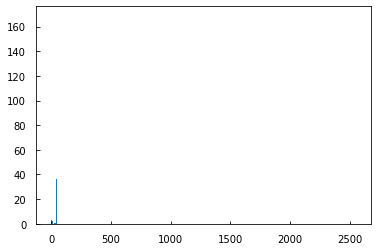

In [51]:
min_period=np.asarray(min_period)
plt.hist(min_period, bins=np.arange(min_period.min(), min_period.max()+1))

In [73]:
for i in range(0,len(min_period)):
               print(high_spikes[i], float(min_period[i])/22.0)

(Timestamp('2019-08-15 10:55:58'), 1.0)
(Timestamp('2019-08-15 11:18:08'), 1.0)
(Timestamp('2019-08-15 11:40:19'), 0.9090909090909091)
(Timestamp('2019-08-15 12:00:30'), 1.0)
(Timestamp('2019-08-15 12:22:41'), 1.0)
(Timestamp('2019-08-15 12:44:52'), 9.772727272727273)
(Timestamp('2019-08-15 16:20:27'), 0.18181818181818182)
(Timestamp('2019-08-15 16:24:41'), 50.04545454545455)
(Timestamp('2019-08-16 10:46:21'), 0.4090909090909091)
(Timestamp('2019-08-16 10:55:52'), 0.9545454545454546)
(Timestamp('2019-08-16 11:17:08'), 0.5)
(Timestamp('2019-08-16 11:28:08'), 1.0)
(Timestamp('2019-08-16 11:50:19'), 1.0)
(Timestamp('2019-08-16 12:12:30'), 1.0)
(Timestamp('2019-08-16 12:34:40'), 5.863636363636363)
(Timestamp('2019-08-16 14:43:45'), 4.0)
(Timestamp('2019-08-16 16:12:28'), 0.9090909090909091)
(Timestamp('2019-08-16 16:32:39'), 7.045454545454546)
(Timestamp('2019-08-16 19:07:55'), 1.9090909090909092)
(Timestamp('2019-08-16 19:50:17'), 1.0)
(Timestamp('2019-08-16 20:12:28'), 1.0)
(Timestamp('2

In [66]:
for i in min_period:
    print(float(min_period[i])/22.0)


1.0
1.0
0.909090909091
1.0
1.0
9.77272727273
0.181818181818
50.0454545455
0.409090909091
0.954545454545
0.5
1.0
1.0
1.0
5.86363636364
4.0
0.909090909091
7.04545454545
1.90909090909
1.0
1.0
1.0
0.909090909091
0.0909090909091
2.90909090909
1.0
0.909090909091
0.0909090909091
0.909090909091
2.0
1.0
3.90909090909
1.90909090909
1.0
1.0
1.0
0.909090909091
1.0
3.0
1.90909090909
1.0
1.0
1.90909090909
1.0
2.0
0.909090909091
0.0909090909091
0.909090909091
1.0
1.0
0.909090909091
1.0
1.0
1.0
1.0
0.909090909091
0.0909090909091
0.909090909091
1.0
1.0
1.0
1.0
0.909090909091
1.0
1.0
2.90909090909
1.0
2.0
1.0
51.6818181818
1.0
1.0
1.0
1.0
0.909090909091
1.0
1.0
1.0
0.909090909091
0.0909090909091
0.909090909091
1.0
2.0
0.909090909091
1.0
1.0
2.90909090909
0.0909090909091
0.909090909091
1.0
1.0
2.0
0.909090909091
0.0909090909091
0.909090909091
1.0
1.0
1.0
1.90909090909
0.0909090909091
0.909090909091
1.0
2.0
26.7727272727
0.318181818182
1.0
1.0
1.0
0.909090909091
0.0909090909091
3.90909090909
1.0
1.0
0.909

In [103]:
for i in TAWO_OPC.iloc[-200].to_dict().values():
    print(i)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
4.0
1.0
0.0
0.0
0
0.0
6.025583396596711e-44
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-0.7793545433737705
0.04471898078918457
0.04646696895360947
31.114671549553677
4.95
1.0101010101010102
0.04646696895360947
16.5000033
0.0612182307927787
33295.0


In [ ]:
b0                        3
b1                        0
b2                        0
b3                        0
b4                        0
b5                        0
b6                        0
b7                        0
b8                        0
b9                        0
b10                   16385
b11                       0
b12                       0
b13                       0
b14                       0
b15                     256
b16                     128
b17                       0
b18                       0
b19                       0
b20                       0
b21                       0
b22                     768
b23                   49368
MToF                      0
period                    0
FlowRate           0.166667
OPC-T              -44.3164
OPC-RH             0.755322
pm1            -4.44093e-16
pm2             6.73233e-25
pm10           -4.31844e+37
Check                  1049
total_counts            inf
OPC_conc                inf
Name: 2019-08-31 16:15:02,

In [86]:
for i in TAWO_OPC.columns:
    print(i)

b0
b1
b2
b3
b4
b5
b6
b7
b8
b9
b10
b11
b12
b13
b14
b15
b16
b17
b18
b19
b20
b21
b22
b23
MToF
period
FlowRate
OPC-T
OPC-RH
pm1
pm2
pm10
Check
total_counts
OPC_conc


In [107]:
TAWO_OPC.loc[high_spikes].to_csv('/Users/heather/Desktop/TAWO_OPC_bad_data.csv', sep=',',header=True, index=True)

In [112]:
good_data = TAWO_OPC.drop(high_spikes)
good_data = good_data.drop(low_spikes)

In [113]:
good_data.to_csv('/Users/heather/Desktop/TAWO_OPC_good_data.csv', sep=',',header=True, index=True)